# Finetunning pretained CNN

In [4]:
import torch



In [3]:
from pathlib import Path
from torchvision.io import read_image
import matplotlib.pyplot as plt

from torchvision.io import read_image
from torchvision.transforms import v2

In [63]:
# import Dataset
import numpy as np
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision import tv_tensors
# We create a dataset for binary classification
class GraspDataset(Dataset):
    """
        Grasp verification Dataset
    """
    def __init__(self, pos_path, neg_path, balance=True, transform=None):
        """
            Args:
                pos_path (Path): Path to positive samples
                neg_path (Path): Path to negative samples
                balance (bool): If True, balance the dataset
                transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.pos_path = pos_path
        self.neg_path = neg_path
        self.pos_files = list(pos_path.glob("*.png"))
        # as str
        self.pos_files = [str(p) for p in self.pos_files]
        self.neg_files = list(neg_path.glob("*.png"))
        # as str
        self.neg_files = [str(p) for p in self.neg_files]

        # check empty image files by checking sie
        self.pos_files = [f for f in self.pos_files if Path(f).stat().st_size > 1]
        self.neg_files = [f for f in self.neg_files if Path(f).stat().st_size > 1]

        if balance:
            min_len = min(len(self.pos_files), len(self.neg_files))
            self.pos_files = self.pos_files[:min_len]
            self.neg_files = self.neg_files[:min_len]


        self.files = self.pos_files + self.neg_files
        # create equivalent list of idxs
        self.targets = [1]*len(self.pos_files) + [0]*len(self.neg_files)
        # create random permutation
        # self.perm = torch.randperm(len(self.files))
        # self.files = [self.files[i] for i in self.perm]
        # self.targets = [self.targets[i] for i in self.perm]
        self.transform = transform
    def __len__(self):
        return len(self.pos_files) + len(self.neg_files)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        assert idx < len(self), "Index out of bounds"
        img_path = self.files[idx]

        image = tv_tensors.Image(read_image(img_path))
        target = self.targets[idx]

        
        if self.transform:
            image, target = self.transform(image, target)
        return np.array(image), target


from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []

    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.Resize((224, 224)))
    transforms.append(T.ToTensor())
    return T.Compose(transforms)

In [64]:
from torch.utils.data import DataLoader
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
pos_path = Path("/home/pmarg/data/positive/imgs")
neg_path = Path("/home/pmarg/data/negative/imgs")
dataset = GraspDataset(pos_path, neg_path, transform=get_transform(train=True))

dataset.__getitem__(0)[0].shape


(3, 224, 224)

tensor([1, 0, 1, 1])


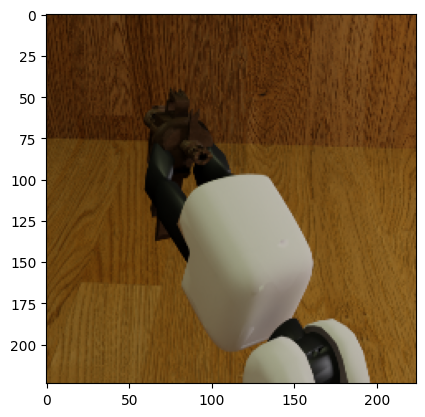

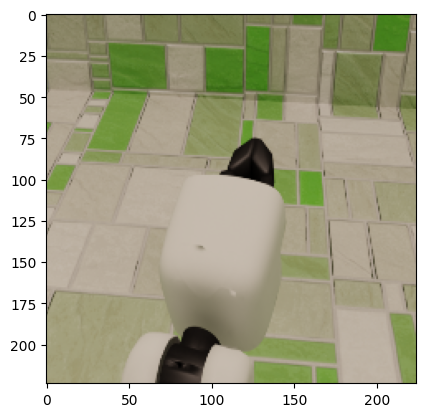

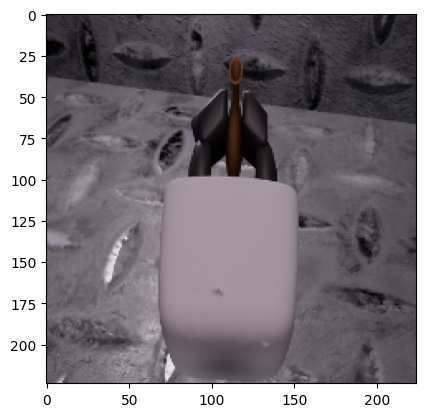

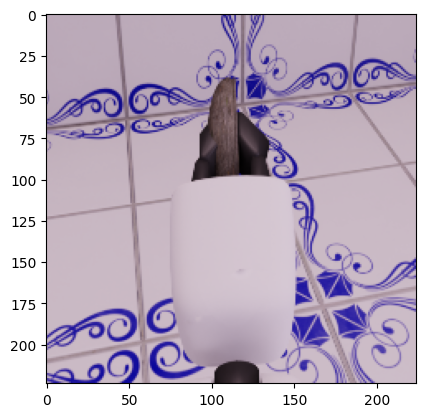

In [65]:

# get lis tof files in pos_path
pos_files = list(pos_path.glob("*.png"))
dataset = GraspDataset(pos_path, neg_path, transform=get_transform(train=True))
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# get a batch of data
for i, (imgs, targets) in enumerate(data_loader):
    print(targets)
    for img in imgs:
        plt.imshow(img.permute(1,2,0))
        plt.show()
    break

In [66]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

for param in model.parameters():
    param.requires_grad = False
import torch.nn as nn
model_header = torch.nn.Sequential(
    nn.Linear(512, 100),
    nn.ReLU(),
    nn.Linear(100, 1),
    nn.Sigmoid()
)
model.fc = model_header

# enable grad for model.fc
for param in model.fc.parameters():
    param.requires_grad = True

Using cache found in /home/pmarg/.cache/torch/hub/pytorch_vision_v0.10.0


In [67]:
dataset = GraspDataset(pos_path, neg_path, transform=get_transform(train=True))
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)


# For Training
images, targets = next(iter(data_loader))
output = model(images)  # Returns losses and detections


In [68]:

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = GraspDataset(pos_path=pos_path, neg_path=neg_path,transform= get_transform(train=True))
dataset_test = GraspDataset(pos_path=pos_path, neg_path=neg_path,transform= get_transform(train=True))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)


Training


In [ ]:
import time
from torch.autograd import Variable
import copy
# import bce loss
from torch.nn import BCELoss
dset_loaders = {
    'train': data_loader,
    'val': data_loader_test
}
use_gpu = False
dset_sizes = {
    'train': len(dataset),
    'val': len(dataset_test)
}
def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=100,dset_loaders=None, dset_sizes = None):
    since = time.time()

    best_model = model
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                mode='train'
                optimizer = lr_scheduler(optimizer, epoch)
                model.train()  # Set model to training mode
            else:
                model.eval()
                mode='val'

            running_loss = 0.0
            running_corrects = 0

            counter=0
            # Iterate over data.
            for data in dset_loaders[phase]:
                inputs, labels = data
                # wrap them in Variable
                if use_gpu:
                    try:
                        inputs, labels = Variable(inputs.float().cuda()),                             
                        Variable(labels.long().cuda())
                    except:
                        print(inputs,labels)
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # Set gradient to zero to delete history of computations in previous epoch. Track operations so that differentiation can be done automatically.
                optimizer.zero_grad()
                outputs = model(inputs)
                # if output > 0.5, our prediction is class 1 (grasp)
                # if output <= 0.5, our prediction is class 0 (no grasp)
                preds = (outputs > 0.5).float().reshape(-1)
                labels = labels.reshape(-1).float()
                
                loss = criterion(preds, labels.reshape(-1).float())
                loss.requires_grad = True
                # print('loss done')                
                # Just so that you can keep track that something's happening and don't feel like the program isn't running.
                # if counter%10==0:
                #     print("Reached iteration ",counter)
                counter+=1

                # backward + optimize only if in training phase
                if phase == 'train':
                    # print('loss backward')
                    loss.backward()
                    # print('done loss backward')
                    optimizer.step()
                    # print('done optim')
                # print evaluation statistics
                try:
                    # running_loss += loss.data[0]
                    running_loss += loss.item()
                    # print(labels.data)
                    # print(preds)
                    running_corrects += torch.sum(preds == labels.data)
                    # print('running correct =',running_corrects)
                except:
                    print('unexpected error, could not calculate loss or do a sum.')
            print('trying epoch loss')
            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects.item() / float(dset_sizes[phase])
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))


            # deep copy the model
            if phase == 'val':
                # if USE_TENSORBOARD:
                #     foo.add_scalar_value('epoch_loss',epoch_loss,step=epoch)
                #     foo.add_scalar_value('epoch_acc',epoch_acc,step=epoch)
                # if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)
                print('new best accuracy = ',best_acc)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('returning and looping back')
    return best_model
    

BASE_LR = 0.001
EPOCH_DECAY = 30 # number of epochs after which the Learning rate is decayed exponentially.
DECAY_WEIGHT = 0.1 # factor by which the learning rate is reduced.


# This function changes the learning rate over the training model.
def exp_lr_scheduler(optimizer, epoch, init_lr=0.5, lr_decay_epoch=EPOCH_DECAY):
    """Decay learning rate by a factor of DECAY_WEIGHT every lr_decay_epoch epochs."""
    lr = init_lr * (DECAY_WEIGHT**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer


### SECTION 4 : DEFINING MODEL ARCHITECTURE.

# We use Resnet18 here. If you have more computational power, feel free to swap it with Resnet50, Resnet100 or Resnet152.
# Since we are doing fine-tuning, or transfer learning we will use the pretrained net weights. In the last line, the number of classes has been specified.
# Set the number of classes in the config file by setting the right value for NUM_CLASSES.


criterion = nn.BCELoss()

if use_gpu:
    criterion.cuda()
    model.cuda()

from torch import optim

optimizer_ft = optim.RMSprop(model.parameters(), lr=0.0001)



# Run the functions and save the best model in the function model_ft.
model_ft = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=1, dset_loaders=dset_loaders, dset_sizes=dset_sizes)

Epoch 0/0
----------
LR is set to 0.5
tensor([1., 0.]) tensor([1., 0.])
tensor([1., 1.]) tensor([1., 1.])
tensor([1., 0.]) tensor([1., 0.])
tensor([1., 1.]) tensor([1., 1.])
tensor([1., 1.]) tensor([1., 0.])
tensor([1., 0.]) tensor([1., 0.])
tensor([1., 0.]) tensor([1., 0.])
tensor([1., 1.]) tensor([0., 1.])
tensor([1., 0.]) tensor([0., 0.])
tensor([1., 1.]) tensor([1., 0.])
tensor([0., 1.]) tensor([1., 0.])
tensor([1., 1.]) tensor([1., 1.])
tensor([1., 1.]) tensor([1., 1.])
tensor([1., 1.]) tensor([0., 1.])
tensor([0., 1.]) tensor([0., 1.])
tensor([0., 1.]) tensor([1., 1.])
tensor([1., 1.]) tensor([1., 1.])
tensor([1., 1.]) tensor([1., 0.])
tensor([1., 1.]) tensor([0., 1.])
tensor([0., 1.]) tensor([1., 1.])
tensor([1., 1.]) tensor([0., 1.])
tensor([1., 1.]) tensor([0., 0.])
tensor([1., 1.]) tensor([0., 1.])
tensor([1., 1.]) tensor([1., 1.])
tensor([1., 1.]) tensor([0., 0.])
tensor([1., 1.]) tensor([1., 1.])
tensor([1., 1.]) tensor([0., 1.])
tensor([1., 1.]) tensor([1., 0.])
tensor([1.

In [32]:
dset_loaders["train"]